In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [ ]:
path=tf.keras.utils.get_file('/content/bsd_images','https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300-images.tgz',untar=True)

22216704/22211847 [==============================] - 2s 0us/step


In [ ]:
!tar -xf bsd_images.tar.gz

In [ ]:
len(os.listdir('./BSDS300/images/train'))

200

In [ ]:
len(os.listdir('./BSDS300/images/test'))

100

In [ ]:
trainX,trainY=[],[]

for file in os.listdir("./BSDS300/images/train"):
    path="./BSDS300/images/train/"
    img=tf.io.read_file(path+file)
    img=tf.image.decode_jpeg(img,channels=3)

    for _ in range(100):
        hr=tf.image.random_crop(img,[50,50,3])
        lr=tf.image.resize(hr,[25,25])
        lr=tf.image.resize(lr,[50,50])

        trainX.append(np.array(lr))
        trainY.append(np.array(hr))

trainX=np.array(trainX)
trainY=np.array(trainY)


In [ ]:
trainX.shape

(20000, 50, 50, 3)

In [47]:
trainY.shape

(20000, 50, 50, 3)

In [99]:
testX,testY=[],[]

for file in os.listdir("./BSDS300/images/test"):
    path="./BSDS300/images/test/"
    img=cv2.imread(path+file)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    h,w,_=img.shape
    if h>=w:
        img=cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE)
    hr=img.copy()

    h,w,_=img.shape
    lr=cv2.resize(img,(w//2,h//2))
    lr=cv2.resize(lr,(w,h))
    testX.append(lr)
    testY.append(hr)

        
testX=np.array(testX)
testY=np.array(testY)

In [100]:
print(testX.shape,testY.shape)

(100, 321, 481, 3) (100, 321, 481, 3)


In [48]:
def REDNet20():
    residual_layers=[]
    inputs=tf.keras.layers.Input(shape=(None,None,3))

    x=tf.keras.layers.Conv2D(filters=3,kernel_size=3,padding='same',activation='relu')(inputs)
    x=tf.keras.layers.Conv2D(filters=64,kernel_size=64,padding='same',activation='relu')(x)
    x=tf.keras.layers.Conv2D(filters=64,kernel_size=64,padding='same',activation='relu')(x)
    residual_layers.append(x)

    x=tf.keras.layers.Conv2D(filters=64,kernel_size=64,padding='same',activation='relu')(x)
    x=tf.keras.layers.Conv2D(filters=64,kernel_size=64,padding='same',activation='relu')(x)
    residual_layers.append(x)

    x=tf.keras.layers.Conv2D(filters=64,kernel_size=64,padding='same',activation='relu')(x)
    x=tf.keras.layers.Conv2D(filters=64,kernel_size=64,padding='same',activation='relu')(x)
    residual_layers.append(x)

    x=tf.keras.layers.Conv2D(filters=64,kernel_size=64,padding='same',activation='relu')(x)
    x=tf.keras.layers.Conv2D(filters=64,kernel_size=64,padding='same',activation='relu')(x)
    residual_layers.append(x)

    x=tf.keras.layers.Conv2D(filters=64,kernel_size=64,padding='same',activation='relu')(x)

    x=tf.keras.layers.Conv2DTranspose(filters=3,kernel_size=3,padding='same')(x)
    x=tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=3,padding='same',activation='relu')(x)
    x=tf.keras.layers.Add()([x,residual_layers.pop()])
    x=tf.keras.layers.Activation('relu')(x)

    x=tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=3,padding='same',activation='relu')(x)
    x=tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=3,padding='same',activation='relu')(x)
    x=tf.keras.layers.Add()([x,residual_layers.pop()])
    x=tf.keras.layers.Activation('relu')(x)

    x=tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=3,padding='same',activation='relu')(x)
    x=tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=3,padding='same',activation='relu')(x)
    x=tf.keras.layers.Add()([x,residual_layers.pop()])
    x=tf.keras.layers.Activation('relu')(x)

    x=tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=3,padding='same',activation='relu')(x)
    x=tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=3,padding='same',activation='relu')(x)
    x=tf.keras.layers.Add()([x,residual_layers.pop()])
    x=tf.keras.layers.Activation('relu')(x)

    x=tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=3,padding='same',activation='relu')(x)
    x=tf.keras.layers.Conv2DTranspose(filters=3,kernel_size=3,padding='same',activation='relu')(x)

    model=tf.keras.Model(inputs=inputs,outputs=x)
    return model

In [49]:
def psnr_metric(y_true,y_pred):
    return tf.image.psnr(y_true,y_pred,max_val=1.0)

In [119]:
model=REDNet20()
model.compile(optimizer=tf.optimizers.Adam(0.0001),loss='mse',metrics=[psnr_metric])
#tf.keras.utils.plot_model(model)

In [121]:
history=model.fit(trainX,trainY,epochs=1000,validation_split=0.3,batch_size=32,callbacks=[tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_psnr_metric')])

Epoch 1/1000
438/438 [==============================] - 527s 1s/step - loss: 0.0704 - psnr_metric: 16.2987 - val_loss: 0.0113 - val_psnr_metric: 21.3738
Epoch 2/1000
438/438 [==============================] - 527s 1s/step - loss: 0.0097 - psnr_metric: 22.2636 - val_loss: 0.0079 - val_psnr_metric: 23.0025
Epoch 3/1000
438/438 [==============================] - 527s 1s/step - loss: 0.0077 - psnr_metric: 23.2868 - val_loss: 0.0064 - val_psnr_metric: 23.9912
Epoch 4/1000
438/438 [==============================] - 527s 1s/step - loss: 0.0067 - psnr_metric: 23.9347 - val_loss: 0.0058 - val_psnr_metric: 24.3124
Epoch 5/1000
438/438 [==============================] - 527s 1s/step - loss: 0.0059 - psnr_metric: 24.5479 - val_loss: 0.0051 - val_psnr_metric: 24.9930
Epoch 6/1000
438/438 [==============================] - 528s 1s/step - loss: 0.0056 - psnr_metric: 24.7871 - val_loss: 0.0050 - val_psnr_metric: 24.8743


In [122]:
model.save("REDnetSuperRes_.h5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


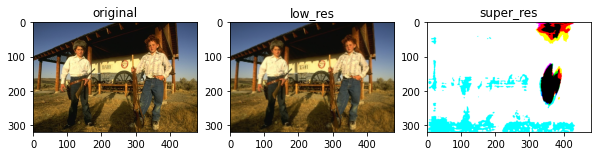

In [124]:
import random
idx=random.randint(0,100)
prediction=model.predict(np.expand_dims(testX[idx],axis=0))

plt.figure(figsize=(10,20))

plt.subplot(1,3,1)
plt.imshow(testY[idx])
plt.title('original')

plt.subplot(1,3,2)
plt.imshow(testX[idx])
plt.title('low_res')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(prediction,axis=0))
plt.title('super_res')

plt.show()

훈련이 잘 안됨...